# Word Clouds

It may be interesting, and possibly useful to look at the most common words in songs by their genre or by the release date (or perhaps both together). Also could be useful to look more closely at length of songs, perhaps looking at word count in addition to just the character count. And also, perhaps we should look closer at the artist level as well.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
import os
from wordcloud import WordCloud
from PIL import Image
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Change below in order to create new word clouds (True) or to use locally stored/previously ran wordclouds (False). As word cloud generation can be time consuming.

In [2]:
generate_word_clouds = False

Read in pickled data.

In [3]:
corpus = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\corpus.pkl')
base_lyrics = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\clean_lyrics.pkl')

Set initial stop words, combo of Scikit-learn's English list and NLTK's English list.

In [4]:
sklearn_stopwords = set(text.ENGLISH_STOP_WORDS)
try:
    nltk_stopwords = set(stopwords.words('english'))
except:
    import nltk
    nltk.download('stopwords')
    nltk_stopwords = set(stopwords.words('english'))

stop_words = sklearn_stopwords | nltk_stopwords

In [5]:
len(sklearn_stopwords), len(nltk_stopwords), len(stop_words)

(318, 179, 378)

Remove stop words from cleaned data.

In [6]:
eng_stop_removed_lyrics = base_lyrics.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

Remove single quote character from the data, this helps in getting corpus specific stopwords, for example, in this case there are a lot of "im" strings which are really the same as "i'm" (of which there are also many). This probably could have been done earlier, but this is an iterative process after all.

In [7]:
cleanish_lyrics = eng_stop_removed_lyrics.apply(lambda x: re.sub("'", "", x))

Use initial run of TfidfVectorizer to find total number of potential features if all words from corpus were included (i.e. min document frequency is 1 (every word that occurs once is included) and max document frequency is 1.0 (includes words that appear in all the songs with no limitation). Keep in mind that the base set of stop words (`stop_words`) have already been removed from the text.

In [8]:
min_df, max_df = 1, 1.0
tfidf_for_stopwords_base = TfidfVectorizer(min_df=min_df, max_df=max_df)
tfidf_for_stopwords_base.fit_transform(cleanish_lyrics)
max_terms = len(tfidf_for_stopwords_base.get_feature_names())
print(max_terms, 'features/terms')

40083 features/terms


Run another TfidfVectorizer using a min_df (minimum document frequency) with a low threshold in order to find rarely used words. In this case the number is .001 and what that means is that words that appear in less than .1% (i.e. 10) of the songs/documents will be added to the TfidfVectorizer's `stop_words_` set.

In [9]:
min_df = .001
tfidf_for_stopwords_min = TfidfVectorizer(min_df=min_df)
tfidf_for_stopwords_min.fit_transform(cleanish_lyrics)
rare_words = tfidf_for_stopwords_min.stop_words_
print(len(rare_words), f'terms occur in less than {min_df*100}% of documents')

34062 terms occur in less than 0.1% of documents


Now run another TfidfVectorizer using a max_df (maximum document frequency) with a relatively high threshold in order to find common words in the corpus. In this case it is set to .25 and that means that any terms that occur in more than 25% (i.e. 2500) of the songs/documents will be added to the TfidfVectorizer's `stop_words_` set.

In [10]:
max_df = .25
tfidf_for_stopwords_max = TfidfVectorizer(max_df=max_df)
tfidf_for_stopwords_max.fit_transform(cleanish_lyrics)
common_words = tfidf_for_stopwords_max.stop_words_
print(len(common_words), f'terms occur in more than {int(max_df*100)}% of documents:')
for word in list(common_words):
    print(word, end=' | ')

15 terms occur in more than 25% of documents:
im | know | oh | love | ill | say | way | come | cant | let | time | like | cause | make | got | 

Update the base stop words set with the rare words and common words.

In [11]:
stop_words.update(rare_words, common_words)
len(stop_words)

34381

Pretty decent number of terms to remove here. Create a term frequency matrix with all these stop words removed using CountVectorizer. This is equivalent to running it with `min_df=.001` and `max_df=.25` as long as the base corpus is identical (`cleanish_lyrics`).

In [12]:
count_vectorizer = CountVectorizer(stop_words=stop_words)
term_frequency_matrix = count_vectorizer.fit_transform(cleanish_lyrics)

Put the term frequency matrix into a data frame for easier manipulation and verbosity.

In [13]:
term_frequency_matrix = pd.DataFrame(data=term_frequency_matrix.toarray(), columns=count_vectorizer.get_feature_names(), index=cleanish_lyrics.index)

Sneak peek.

In [14]:
term_frequency_matrix.head()

,aah,abandon,abandoned,abide,ablaze,able,aboard,absence,absent,absolutely,...,youth,youve,yuh,yup,zero,zip,zombies,zone,zoo,zoom
130667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Add each song's genre to the term_frequency_matrix in order to find each genre's most common words.

In [15]:
term_frequency_matrix['Genre'] = corpus.genre

Group sum of terms by genre and transpose so each term is an index and each genre is a column.

In [16]:
terms_by_genre = term_frequency_matrix.groupby('Genre').sum().T

In [17]:
terms_by_genre.head()

Genre,Country,Electronic,Folk,Hip-Hop,Indie,Jazz,Metal,Pop,R&B,Rock
aah,0,0,0,15,1,1,0,18,0,3
abandon,0,1,0,3,2,0,9,2,0,6
abandoned,1,0,1,9,0,2,7,5,0,5
abide,0,0,0,2,0,1,5,13,0,6
ablaze,0,1,1,0,1,0,16,2,0,2


Find the top 100 top occurring terms for each genre.

In [18]:
def find_top_terms_by_genre(threshold):
    top_terms_by_genre = []
    for genre in terms_by_genre.columns:
        top_terms = terms_by_genre[genre].sort_values(ascending=False).head(threshold)
        top_terms_by_genre.append(set(top_terms.index))

    ttbg = top_terms_by_genre
    all_genre_common = ttbg[0] & ttbg[1] & ttbg[2] & ttbg[3] & ttbg[4] & ttbg[5] & ttbg[6] & ttbg[7] & ttbg[8] & ttbg[9]
    return all_genre_common

In [19]:
all_genre_common = find_top_terms_by_genre(100)
for word in list(all_genre_common):
    print(word, end=' | ')

hear | ive | little | gone | day | feel | need | hold | long | tell | heart | try | world | look | want | away | right | things | night | mind | think | life | 

Update stop words list with above words which occur in every genre.

In [20]:
stop_words.update(all_genre_common)
stop_words_loc = r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\stop_words.pkl'
outfile = open(stop_words_loc, 'wb')
pickle.dump(stop_words, outfile)
outfile.close()

Re-clean the 'cleanish' lyrics (lyrics after removing single quotes and base library stop words) with all the included words in the stop words set.

In [21]:
stop_removed_lyrics = cleanish_lyrics.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

Rename series and export to pickle for future use.

In [22]:
stop_removed_lyrics.name = 'stop_removed_lyrics'
stop_removed_lyrics.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\stop_removed_lyrics.pkl')

Put into a data frame for easier manipulation.

In [23]:
stop_removed_df = pd.DataFrame(stop_removed_lyrics)
stop_removed_df['genre'] = corpus.genre
unique_genres = corpus.genre.unique()

Create 'big strings' for each genre. Takes every genre's cleaned terms and puts them into one long string of text so it can be used to create word clouds.

In [24]:
if generate_word_clouds == True:
    genre_big_strings = {}
    for genre in unique_genres:
        temp_series = stop_removed_df[stop_removed_df['genre'] == genre].stop_removed_lyrics
        genre_big_strings[genre] = temp_series.apply(lambda x: x + ' ').values.sum()

Set up the word cloud object using a local file as a mask.

In [25]:
if generate_word_clouds == True:
    music_mask = np.array(Image.open(r'C:\Users\philb\Pictures\Clipart\musical_note.png'))

    wc = WordCloud(background_color="white", max_words=2000, mask=music_mask,
                   stopwords=stop_words, contour_width=0, collocations=False)

Create word clouds for each genre and export locally for future use.

In [26]:
out_path = r"C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\wordclouds\wordcloud_"

Below cell creates word clouds for each genre, currently commented out since they are stored locally.

In [27]:
if generate_word_clouds == True:
    for genre in unique_genres:
        wc.generate(genre_big_strings[genre])
        filename = out_path + genre + '.png'
        dirname = os.path.dirname(filename)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        with open(filename, 'w'):
            wc.to_file(filename)

Put all word cloud images into a dictionary so it can easily be accessed for plotting.

In [28]:
wordclouds = {}
for genre in unique_genres:
    wordclouds[genre] = Image.open(out_path + genre + '.png')

Plot all the word cloud images.

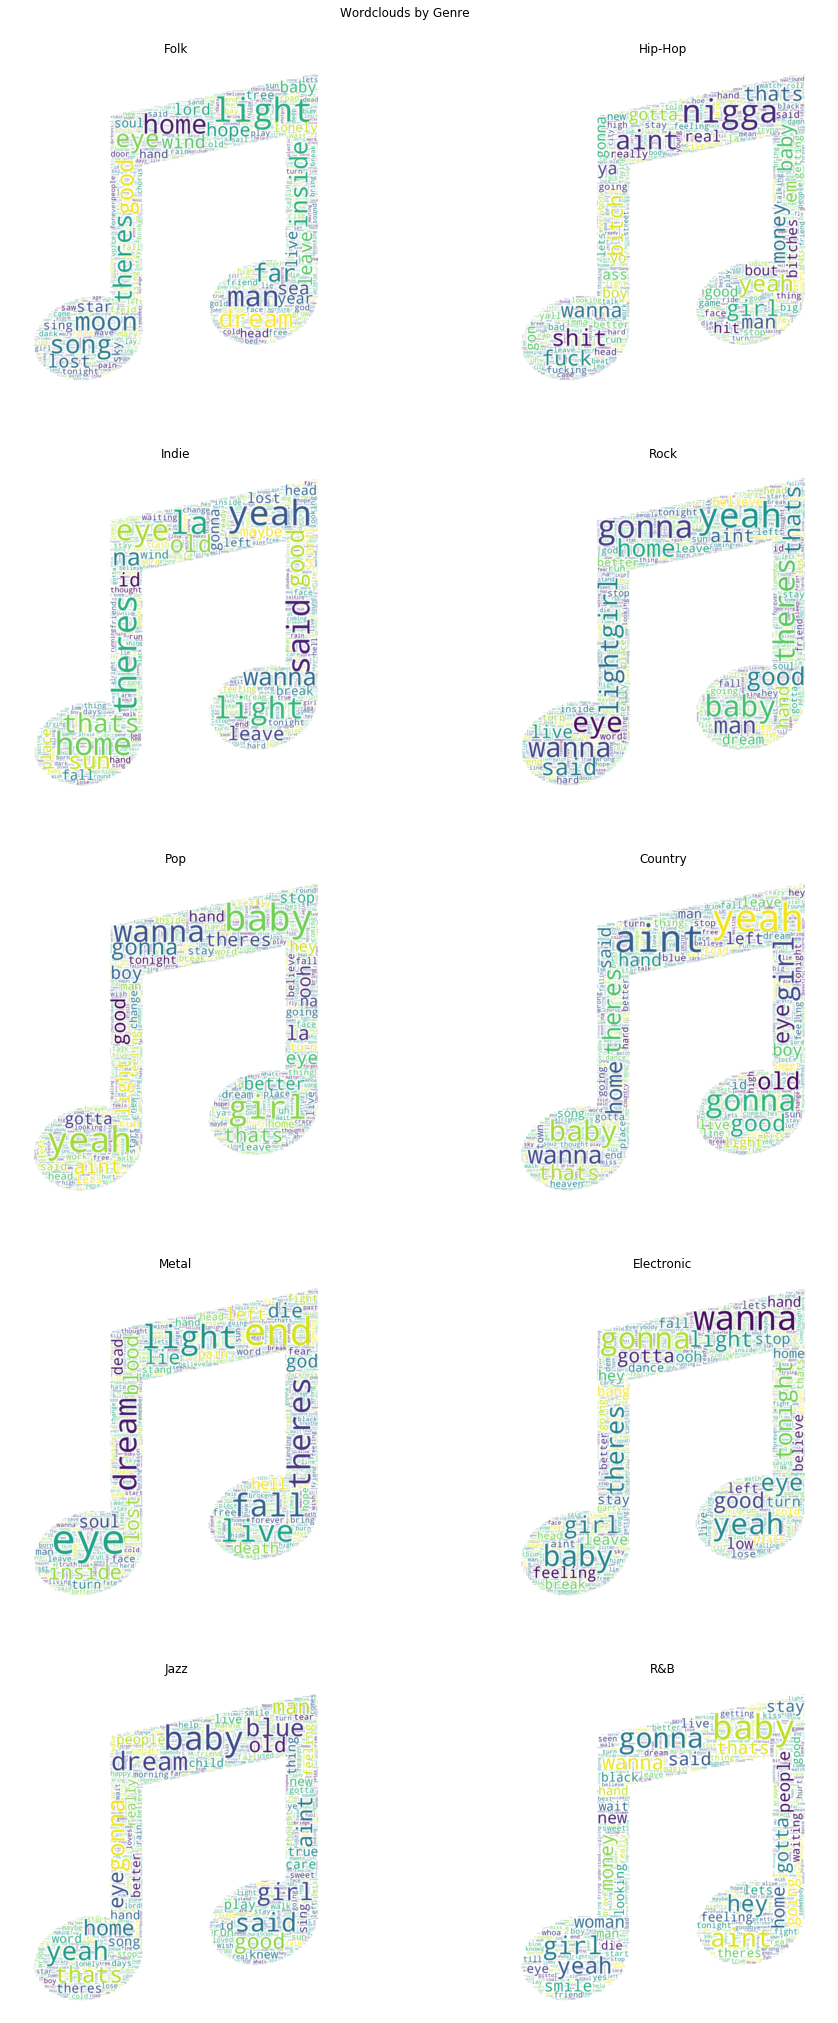

In [29]:
plt.figure(figsize=(16, 36))

plt.suptitle('Wordclouds by Genre', y=.9)

for i, genre in enumerate(unique_genres, 1):
    plt.subplot(5, 2, i)
    plt.imshow(wordclouds[genre], interpolation='bilinear')
    plt.title(genre)
    plt.axis('off')
    
plt.show()

Below creates the big word cloud, but no need to run unless a change is made to the stop words. Uncomment to recreate word clouds.

In [30]:
if generate_word_clouds == True:
    corpus_string = stop_removed_df.stop_removed_lyrics.apply(lambda x: x + ' ').values.sum()

    wc.generate(corpus_string)
    filename = out_path + 'All.png'
    dirname = os.path.dirname(filename)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(filename, 'w'):
        wc.to_file(filename)

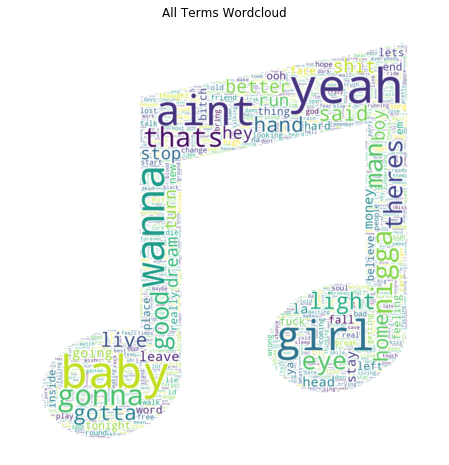

In [31]:
all_wordcloud = Image.open(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\wordclouds\wordcloud_All.png')

plt.figure(figsize=(8,8))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.title('All Terms Wordcloud')
plt.axis('off')
plt.show()